In [106]:
from functions import *
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from pathlib import Path

import pingouin as pg
import seaborn as sns

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr
from scipy.stats import linregress


# load files

In [2]:
# Define paths
BASE_PATH = Path("Z:/yueying/psychedeLights_YueyingDong")
PSYCHOPY_PATH = BASE_PATH / "results/data/psychopy"
PUPIL_CLEAN_PATH = BASE_PATH / "results/data/pupClean"

In [3]:
pupil_clean_files = glob.glob(str(PUPIL_CLEAN_PATH / "*.csv"))
pupClean = pd.concat(
    [pd.read_csv(f).iloc[:, 1:] for f in pupil_clean_files],
    axis=0,
    ignore_index=True
)
print(f"  Loaded {len(pupClean)} trials from {len(pupil_clean_files)} files")

print("\n✓ Data loading complete!")

  Loaded 9066 trials from 3 files

✓ Data loading complete!


In [ ]:
psyFull = pd.read_csv('./psychopy/psyFull.csv')

In [5]:
pupNorm = pupClean.iloc[:,4001:7501].sub(np.nanmean(pupClean.iloc[:,3801:4001],axis =1,)[:,None],axis = 0)
pupNorm.insert(0,'TRIALID',pupClean.TRIALID)

pupNorm = pupNorm[~(pupNorm.iloc[:,1:3501].isnull().sum(axis =1) > 350)]
pupNorm = pupNorm.merge(psyFull[['participant','trlType','TRIALID','cuedItemBri',]],how = 'inner')

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\3796651177.py:1: RuntimeWarning: Mean of empty slice
  pupNorm = pupClean.iloc[:,4001:7501].sub(np.nanmean(pupClean.iloc[:,3801:4001],axis =1,)[:,None],axis = 0)


In [6]:
totalTrl = pupNorm.participant.nunique()*216
trlRemain = pupNorm.shape[0]*100/totalTrl
minTrl = pupNorm.participant.value_counts().min()
maxTrl = pupNorm.participant.value_counts().max()

print(f'After preprocessing, {trlRemain:.3f}% trials remain, out of total {totalTrl}, \n'
      f'ranging from: [{minTrl}-{maxTrl}] per participant')


After preprocessing, 93.329% trials remain, out of total 9504, 
ranging from: [149-216] per participant


# Figure 2A (top & middle)

### permutation

the permutation result might differ

In [72]:
dataN = 35

a = pupNorm.iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[['cuedItemBri']]],axis = 1)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\2718103909.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  a = a.groupby(a.columns // 100, axis=1).mean()


In [8]:
result = cluster_permutation_test(
    data_df=dsPup,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 9 timepoints (indices 26-34), statistic=-23.039
  Largest observed cluster: 9 timepoints (indices 26-34), statistic=-23.039

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -23.039
  Permutation p-value: 0.0430


In [9]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]

cluster_t = [time for time, p in zip(result['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in cluster_t]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.022]
Clusters: [(2.6, 3.5)]


In [10]:
pupMean = pupNorm.groupby(['cuedItemBri']).mean(numeric_only=True)
pupSd = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]

pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

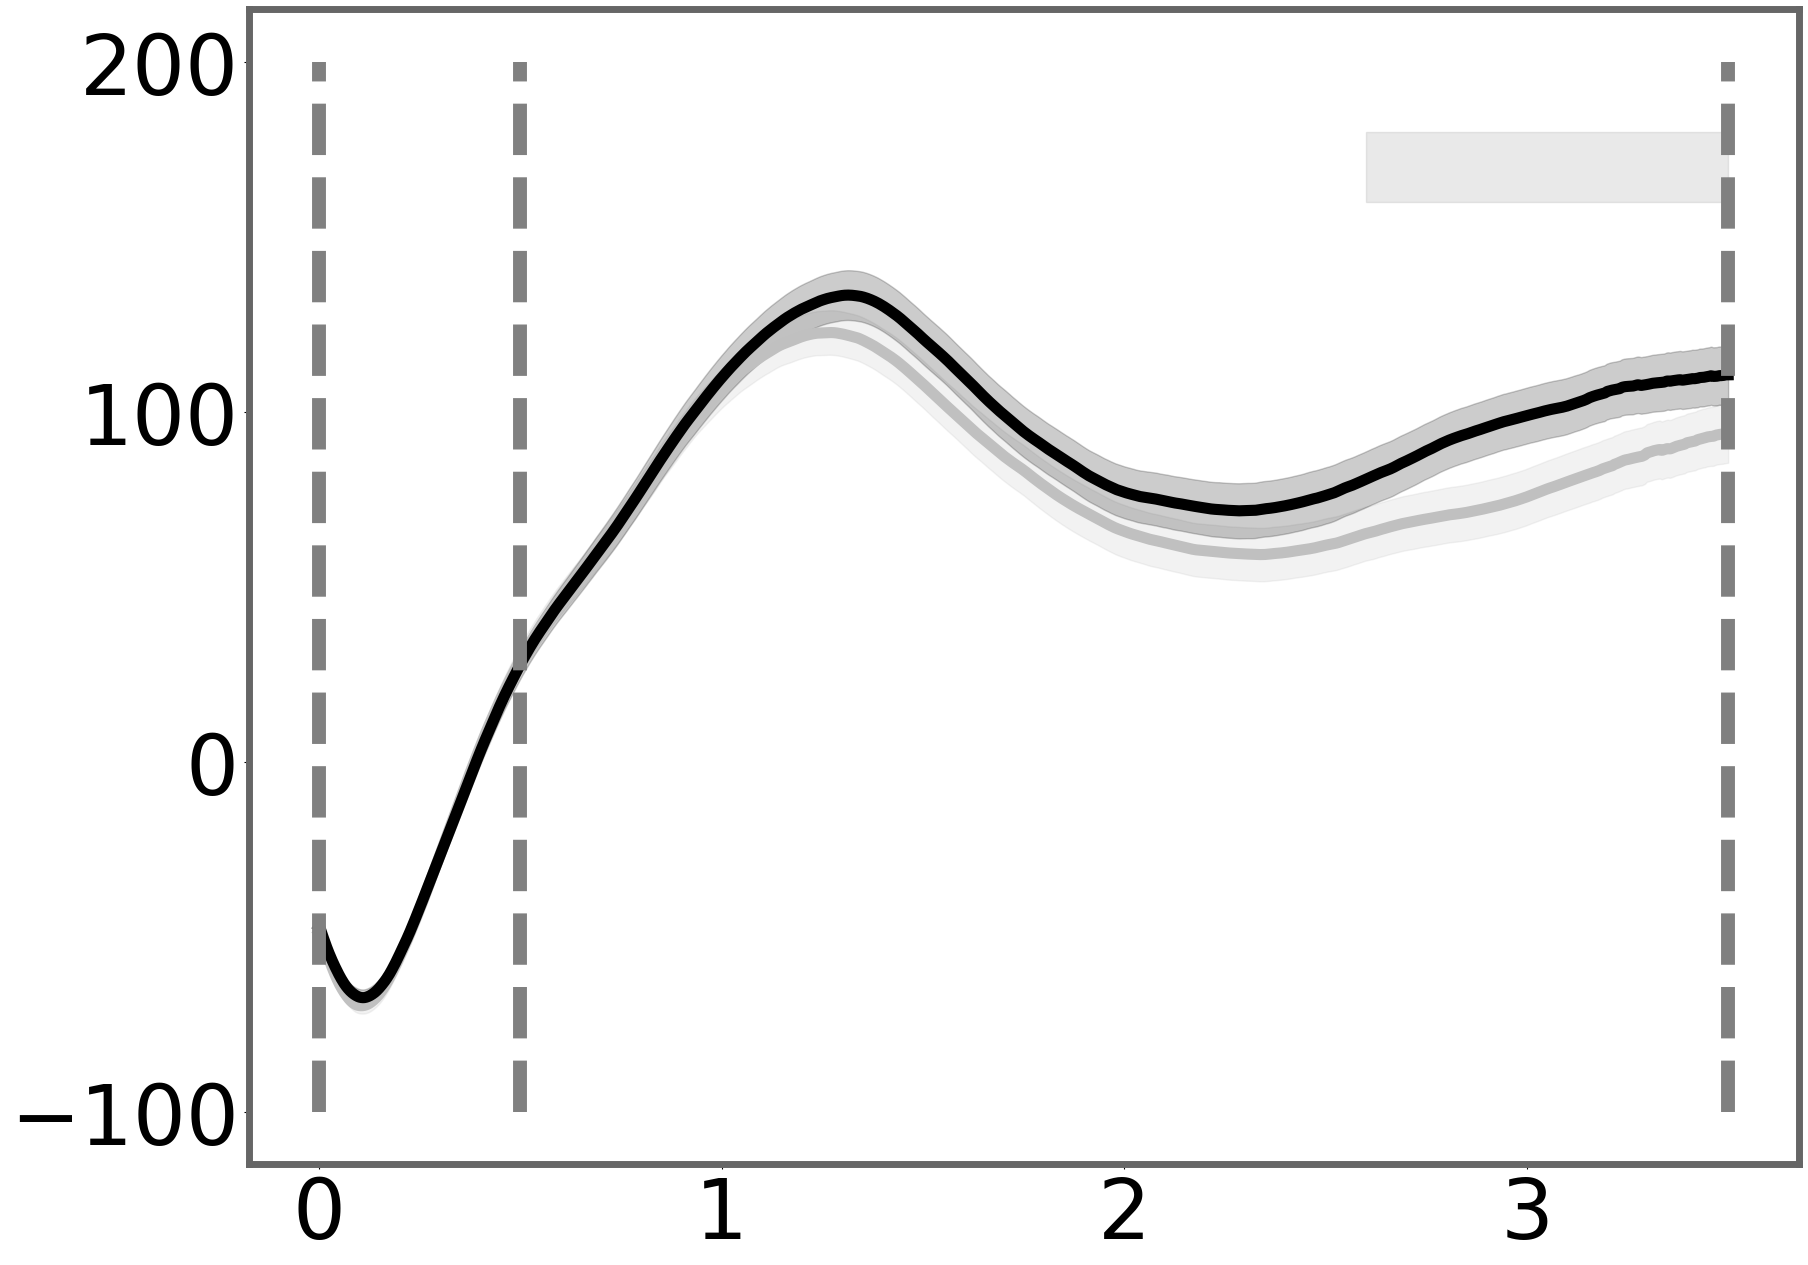

In [11]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 3500
x = np.linspace(0,3.5,lenData)

[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),color = ['silver','black'][i],linewidth = 8) for i in range (2)]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),color =  ['silver','black'][i],alpha = 0.2)for i in range (2)]
plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
[plt.fill_between(i,160,180,color = "#949494",alpha = 0.2) for i in cluster_t]

plt.yticks(fontsize=60)
plt.xticks(fontsize=60)


plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


### average

In [12]:
pupNormMean = pupNorm.iloc[:,-3:]
pupNormMean['meanPup'] = pupNorm.iloc[:,np.r_[501:3501,]].mean(axis = 1)
pupSubj = pupNormMean.groupby(['participant','cuedItemBri']).mean(numeric_only=True)

In [13]:
day_pup = pupNormMean[pupNormMean.cuedItemBri == 'day'].meanPup
night_pup = pupNormMean[pupNormMean.cuedItemBri == 'night'].meanPup

ttest_result = stats.ttest_ind(day_pup, night_pup, nan_policy='omit')
t_value = ttest_result.statistic

bf = pg.bayesfactor_ttest(t=t_value, nx=len(day_pup), ny=len(night_pup))

print(f'day vs night, meanPup: t={t_value:.3f}, p={ttest_result.pvalue:.3f}')
print(f'Bayes Factor: {bf:.3f}')

day vs night, meanPup: t=-2.049, p=0.040
Bayes Factor: 0.195


C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\1410485788.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 5}` instead.

  f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=["#838383","#000000",],


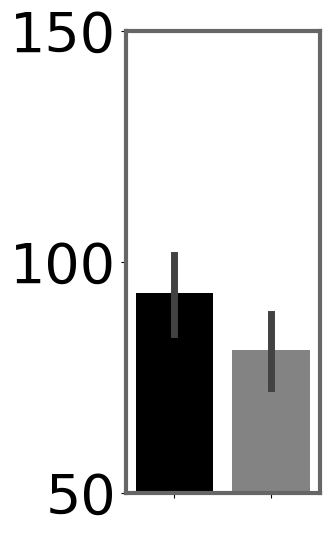

In [14]:
fs(2.5,6)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=["#838383","#000000",],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupNormMean)



plt.ylim(50,150)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.tick_params(axis = 'y',labelsize=40)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

# Figure 2B (top & middle)

In [73]:
pupMean = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
pupSd = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

In [74]:
dsPup = pd.concat([a,pupNorm[['trlType','cuedItemBri']]],axis = 1)
dsPup_visual = dsPup[dsPup.trlType == 'visual'].reset_index(drop=True)
dsPup_verbal = dsPup[dsPup.trlType == 'verbal'].reset_index(drop=True)

In [59]:
cList = ['#ba88e9','#5c1486','#60d062','#1e681f']

### permutation

In [77]:
result_verbal = cluster_permutation_test(
    data_df=dsPup_verbal,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  No significant clusters found in observed data


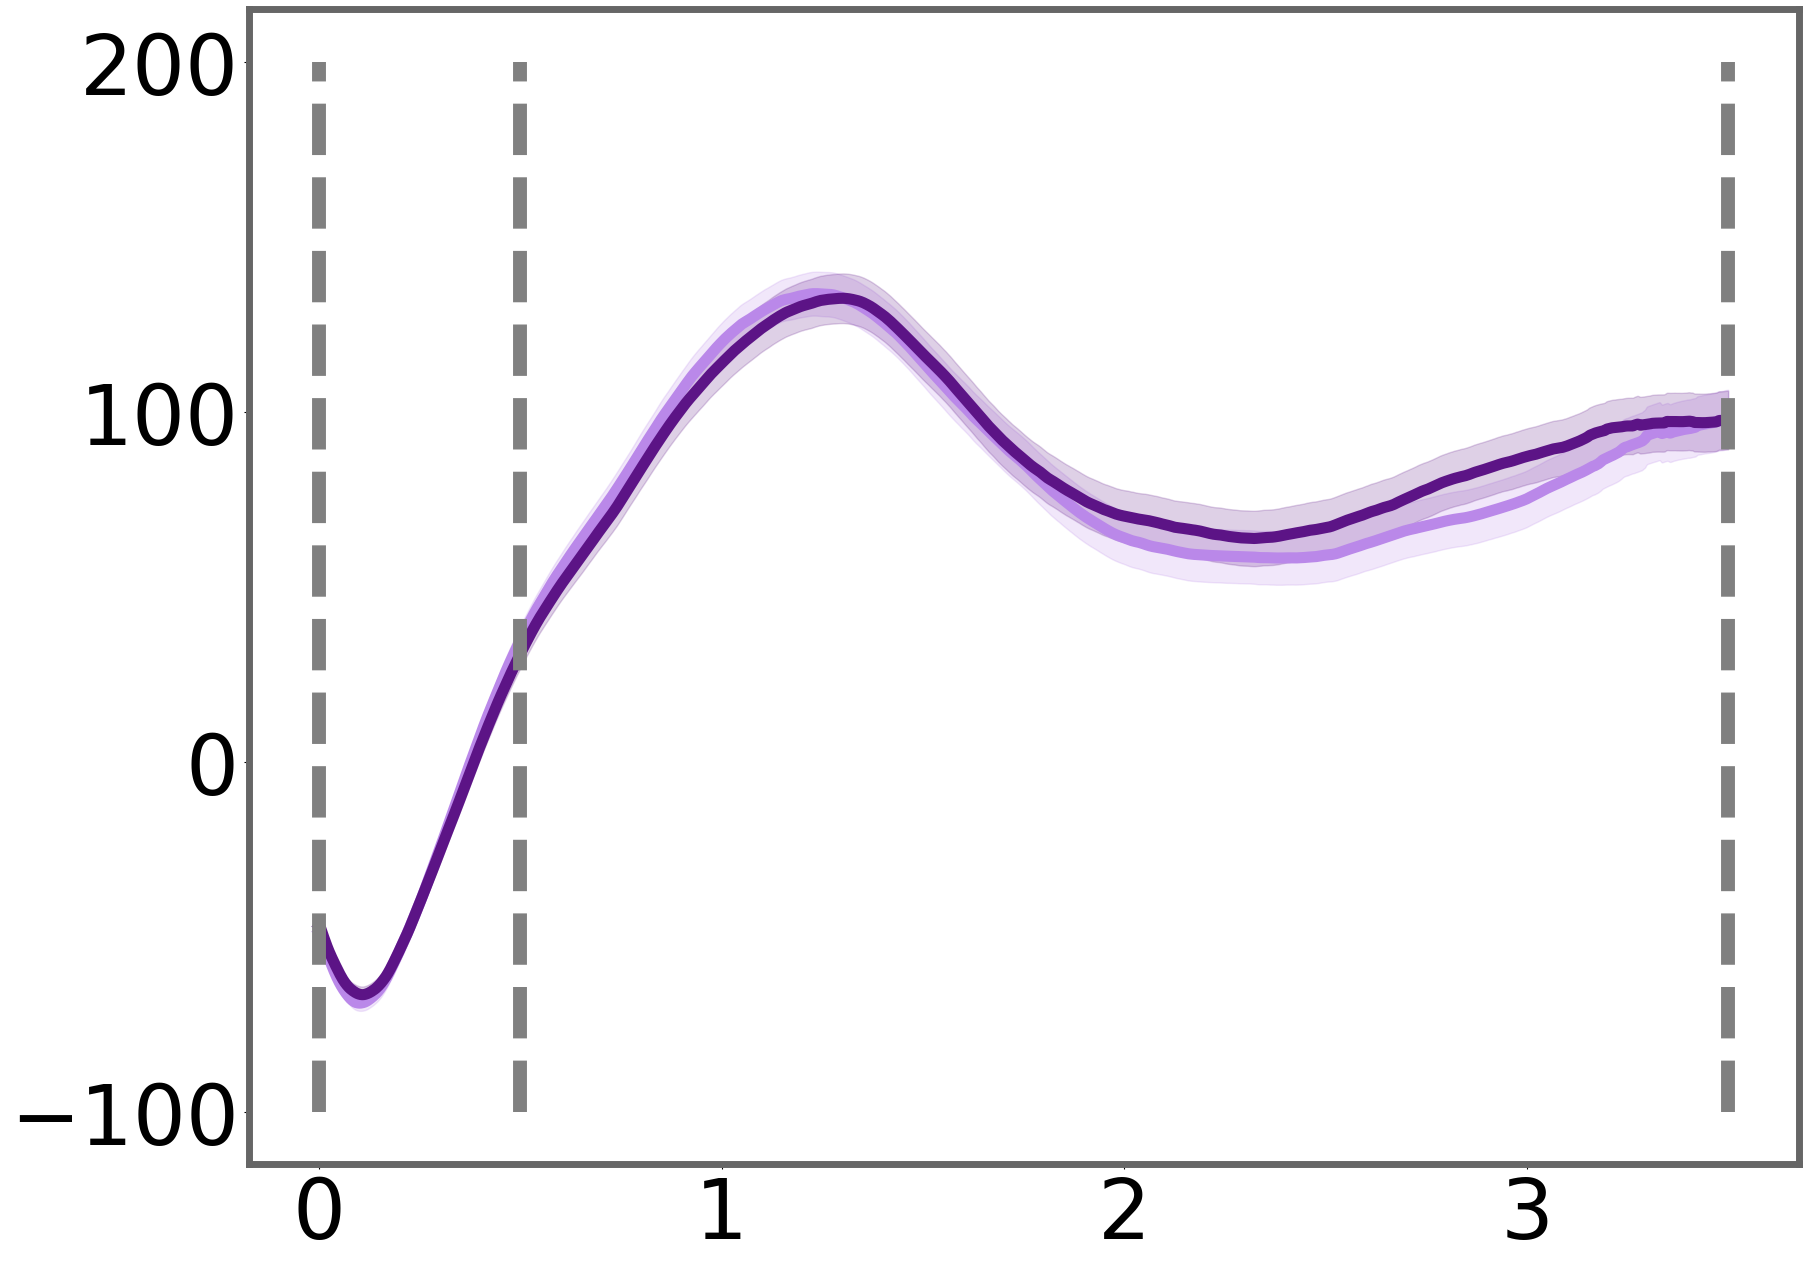

In [78]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

In [79]:
result_visual = cluster_permutation_test(
    data_df=dsPup_visual,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 7 timepoints (indices 11-17), statistic=-28.564
  Largest observed cluster: 7 timepoints (indices 11-17), statistic=-28.564

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -28.564
  Permutation p-value: 0.0324


In [80]:
cluster_pvalues = [
    np.mean(cluster_stat > result_visual['null_distribution'])
    for cluster_stat in [result_visual['observed_stats'][cluster].sum() 
                         for cluster in result_visual['observed_clusters']]
]

cluster_t = [time for time, p in zip(result_visual['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in cluster_t]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.0328, 0.0154]
Clusters: [(1.1, 1.8), (2.5, 3.5)]


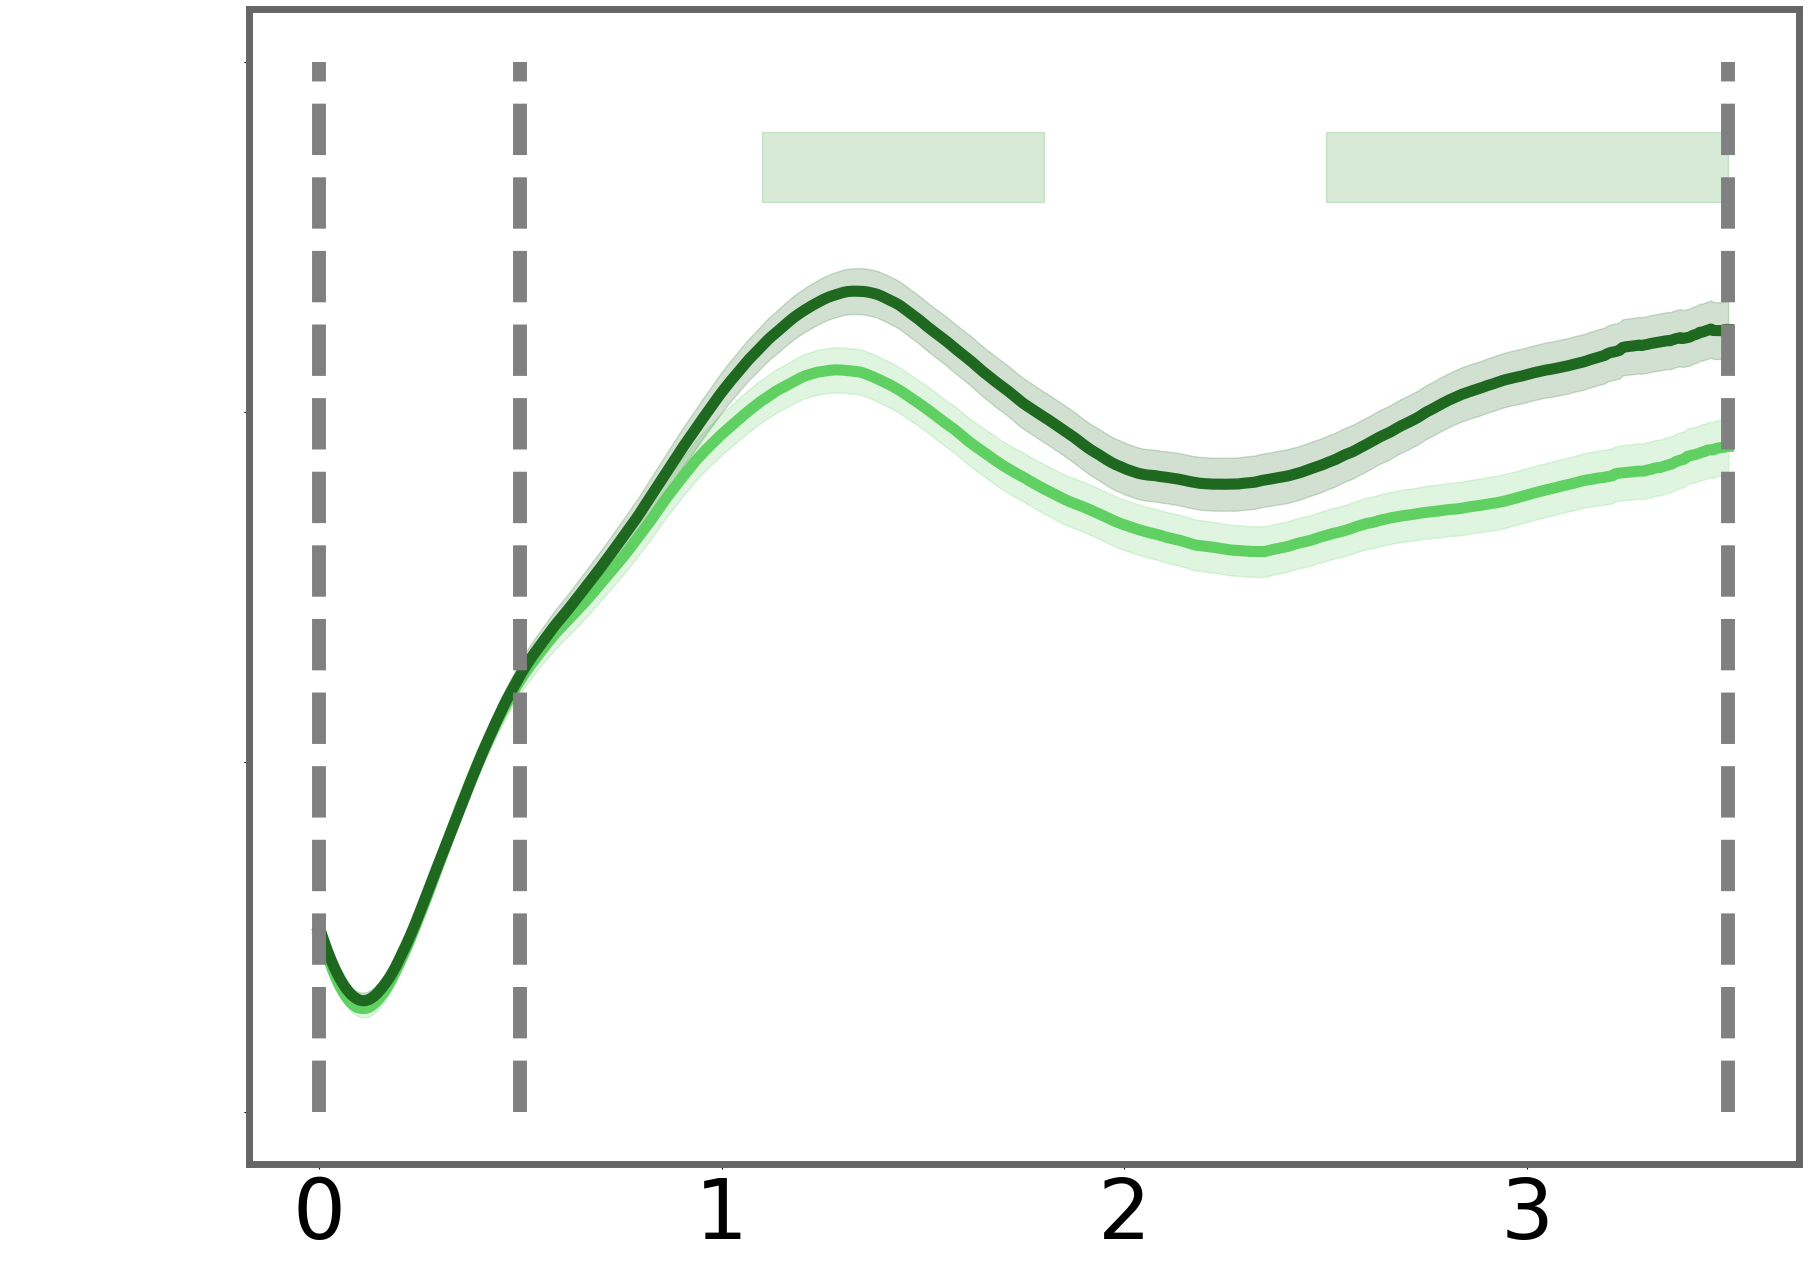

In [81]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]
[plt.fill_between(i,160,180,color = "#359937",alpha = 0.2) for i in cluster_t]

plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

### average

In [23]:
visPup = pupNormMean[pupNormMean.trlType == 'visual']
verPup = pupNormMean[pupNormMean.trlType == 'verbal']

In [24]:
day_pup = visPup[visPup.cuedItemBri == 'day'].meanPup
night_pup = visPup[visPup.cuedItemBri == 'night'].meanPup

ttest_result = stats.ttest_ind(day_pup, night_pup, nan_policy='omit')
t_value = ttest_result.statistic

bf = pg.bayesfactor_ttest(t=t_value, nx=len(day_pup), ny=len(night_pup))

print(f'day vs night (visual), meanPup: t={t_value:.3f}, p={ttest_result.pvalue:.3f}')
print(f'Bayes Factor: {bf:.3f}')

day vs night (visual), meanPup: t=-2.566, p=0.010
Bayes Factor: 0.898


In [25]:
day_pup = verPup[verPup.cuedItemBri == 'day'].meanPup
night_pup = verPup[verPup.cuedItemBri == 'night'].meanPup

ttest_result = stats.ttest_ind(day_pup, night_pup, nan_policy='omit')
t_value = ttest_result.statistic

bf = pg.bayesfactor_ttest(t=t_value, nx=len(day_pup), ny=len(night_pup))

print(f'day vs night (verbal), meanPup: t={t_value:.3f}, p={ttest_result.pvalue:.3f}')
print(f'Bayes Factor: {bf:.3f}')

day vs night (verbal), meanPup: t=-0.369, p=0.712
Bayes Factor: 0.036


C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\3314329341.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 5}` instead.

  f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#5c1486','#ba88e9',],


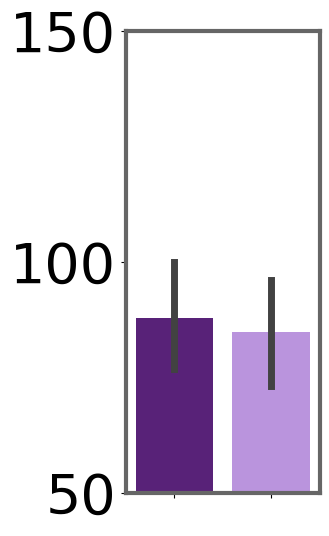

In [26]:
fs(2.5,6)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#5c1486','#ba88e9',],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupNormMean[pupNormMean.trlType == 'verbal'])



plt.ylim(50,150)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.tick_params(axis = 'y',labelsize=40)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\2698017676.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 5}` instead.

  f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#60d062','#1e681f',],


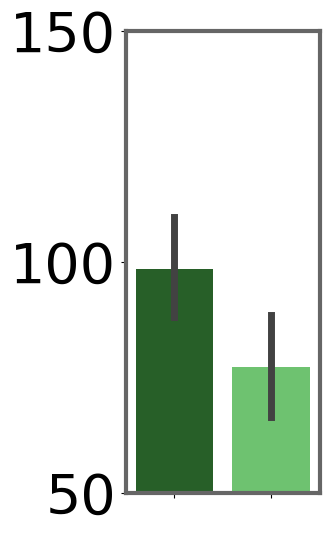

In [27]:
fs(2.5,6)
fig, ax = plt.subplots()

colors = ['#ba88e9','#5c1486','#1e681f','#60d062',]
f = sns.barplot(x = 'cuedItemBri',hue = 'cuedItemBri',palette=['#60d062','#1e681f',],
            order = ['night','day',],linewidth = 5, errwidth=5,
            y = 'meanPup',data = pupNormMean[pupNormMean.trlType == 'visual'])



plt.ylim(50,150)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.tick_params(axis = 'y',labelsize=40)
plt.xlabel('',c = 'white')
plt.ylabel('',c = 'white')
plt.xticks(c = 'white');


ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)

# Figure 2A (bottom panel)

In [28]:
noDistractorTrlsOnly = False
perms = 5000


In [29]:
#load trls
behavTag = psyFull[['TRIALID','participant','trlType','distractorType_visVer','correctness','rt']]
corrTrials = behavTag[behavTag.correctness == 1].TRIALID.values
incorrTrials = behavTag[behavTag.correctness == 0].TRIALID.values

### permutation

In [30]:
#get correct trials only
pupMean = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

#prepare for permutation
a = pupNorm[pupNorm.TRIALID.isin(corrTrials)].iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[pupNorm.TRIALID.isin(corrTrials)][['trlType','cuedItemBri']]],axis = 1)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\3948144563.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  a = a.groupby(a.columns // 100, axis=1).mean()


In [31]:
result = cluster_permutation_test(
    data_df=dsPup,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 7 timepoints (indices 26-32), statistic=-16.426
  Largest observed cluster: 7 timepoints (indices 26-32), statistic=-16.426

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -16.426
  Permutation p-value: 0.0648


In [32]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]
cluster_t = [time for time, p in zip(result['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in cluster_t]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.0294]
Clusters: [(2.6, 3.3000000000000003)]


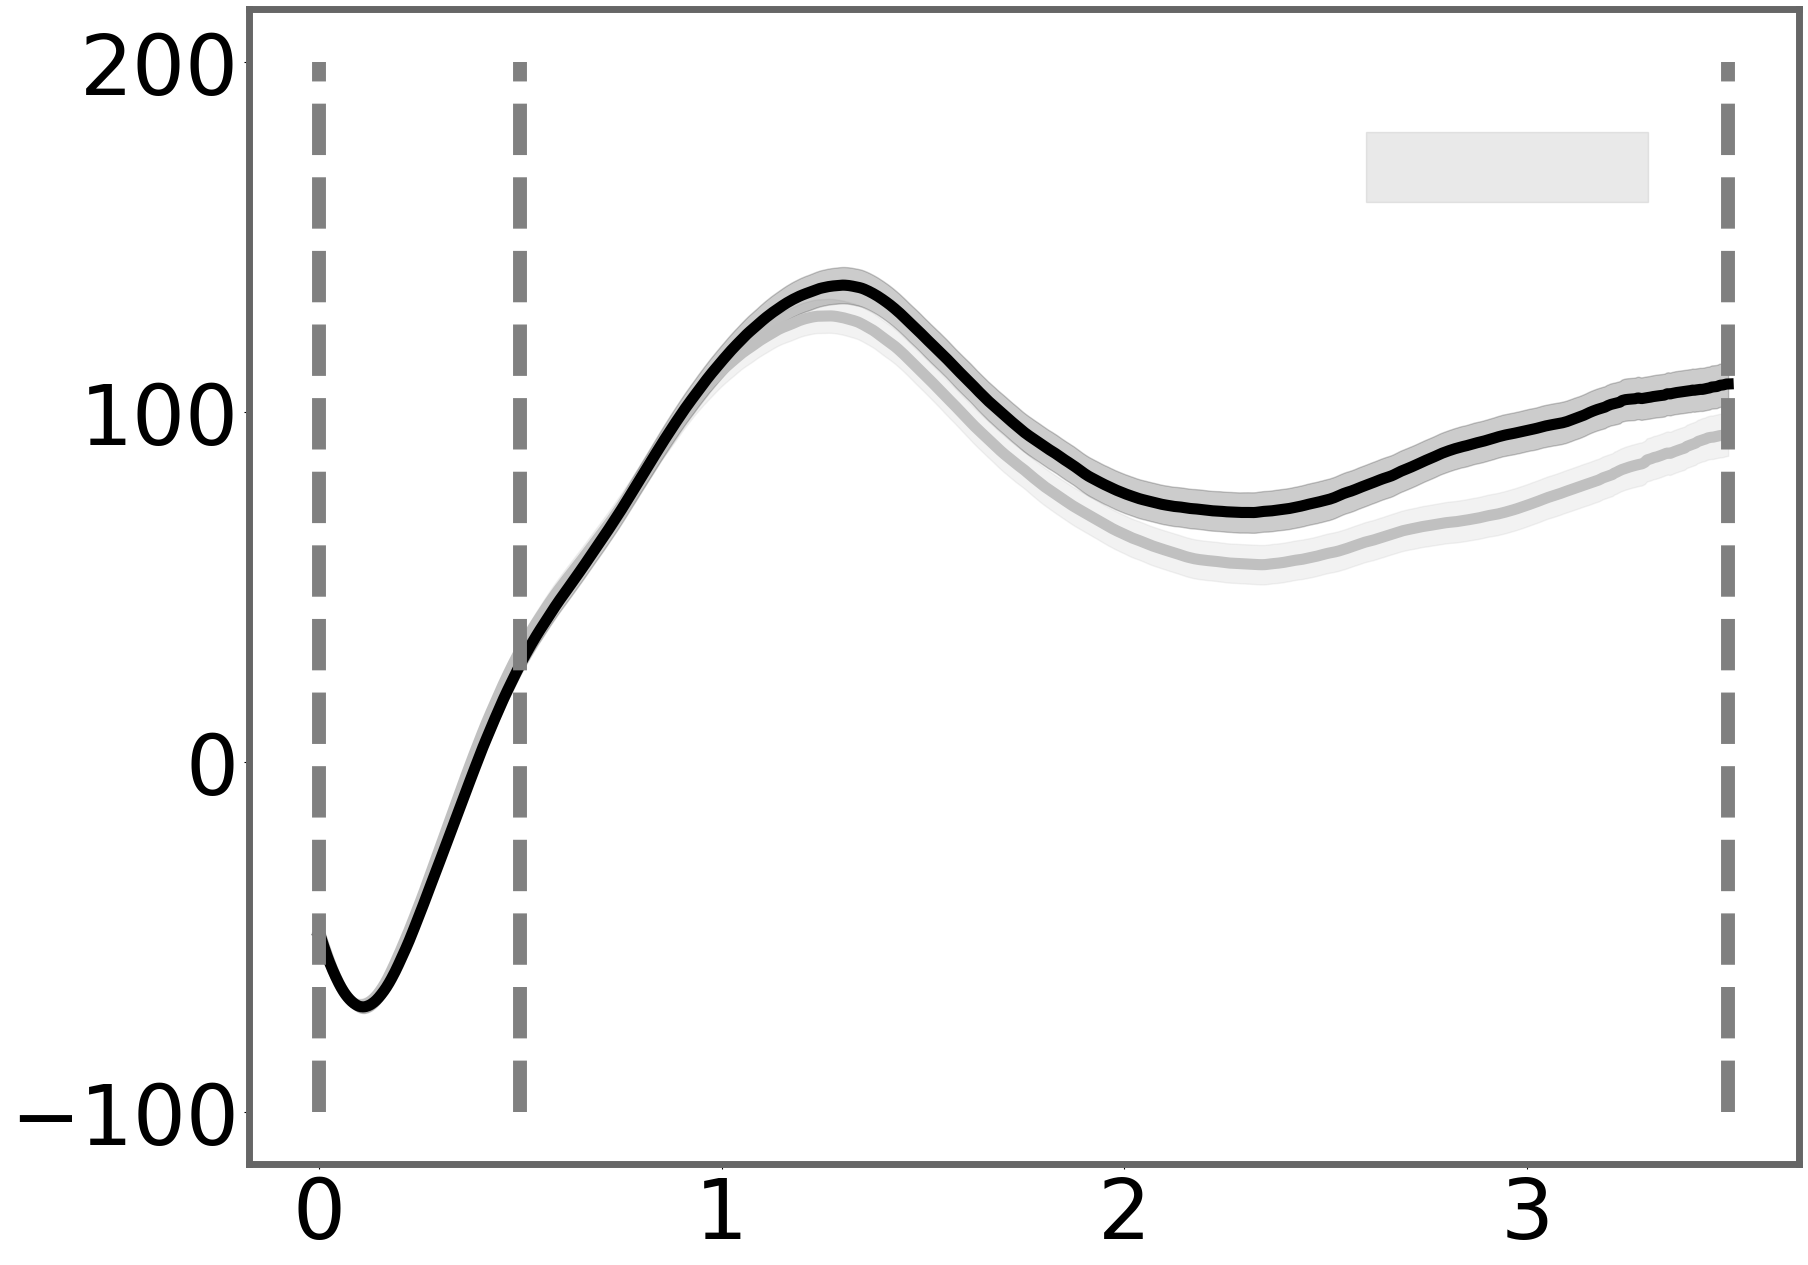

In [33]:
fs(20,15)
fig,ax = plt.subplots()

[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),color = ['silver','black'][i],linewidth = 8) for i in range (2)]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),color =  ['silver','black'][i],alpha = 0.2)for i in range (2)]
plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
[plt.fill_between(i,160,180,color = "#949494",alpha = 0.2) for i in cluster_t]

plt.yticks(fontsize=60)
plt.xticks(fontsize=60)


plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


In [34]:
#get correct trials only
pupMean = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).mean(numeric_only=True).iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['cuedItemBri',]).sem(numeric_only=True).iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

#prepare for permutation
a = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[pupNorm.TRIALID.isin(incorrTrials)][['trlType','cuedItemBri']]],axis = 1)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\3866970065.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  a = a.groupby(a.columns // 100, axis=1).mean()


In [35]:
result = cluster_permutation_test(
    data_df=dsPup,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 2 timepoints (indices 0-1), statistic=-5.138
  Largest observed cluster: 2 timepoints (indices 0-1), statistic=-5.138

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -5.138
  Permutation p-value: 0.1852


In [36]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]

cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in result['observed_clusters']]
cluster_t = [time for time, p in zip(result['observed_clusters'], cluster_pvalues) if p < 0.05]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.0952]
Clusters: []


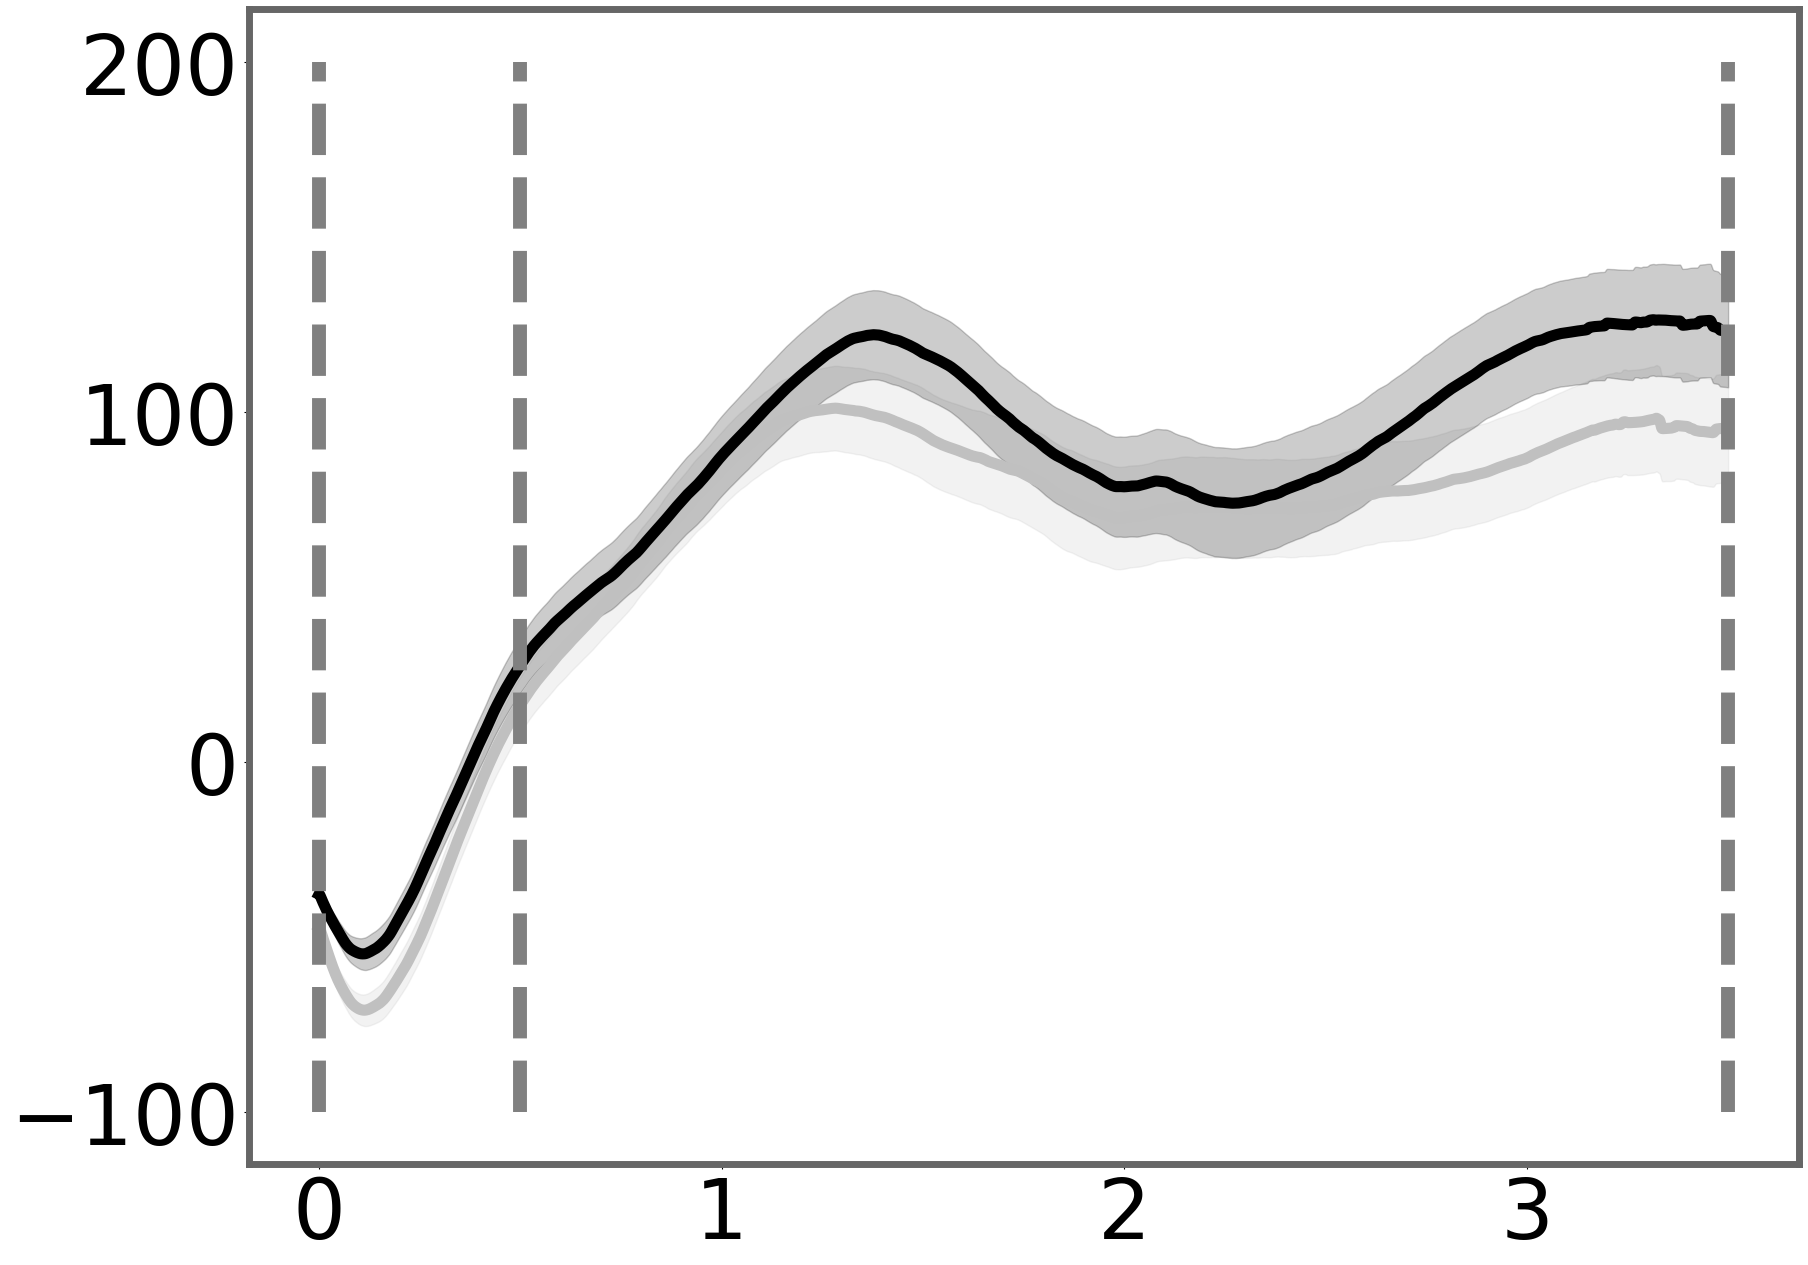

In [37]:
fs(20,15)
fig,ax = plt.subplots()

[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),color = ['silver','black'][i],linewidth = 8) for i in range (2)]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),color =  ['silver','black'][i],alpha = 0.2)for i in range (2)]
plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
[plt.fill_between(i,160,180,color = "#949494",alpha = 0.2) for i in cluster_t]

plt.yticks(fontsize=60)
plt.xticks(fontsize=60)


plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


# Figure 2B (bottom panel)

### correct

In [38]:
#prepare for permutation
a = pupNorm[pupNorm.TRIALID.isin(corrTrials)].iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[pupNorm.TRIALID.isin(corrTrials)][['trlType','cuedItemBri']]],axis = 1)

dsPup_visual = dsPup[dsPup.trlType == 'visual'].reset_index(drop=True)
dsPup_verbal = dsPup[dsPup.trlType == 'verbal'].reset_index(drop=True)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\3857994514.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  a = a.groupby(a.columns // 100, axis=1).mean()


In [39]:
pupMean = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(corrTrials)].drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

In [40]:
result_verbal = cluster_permutation_test(
    data_df=dsPup_verbal,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  No significant clusters found in observed data


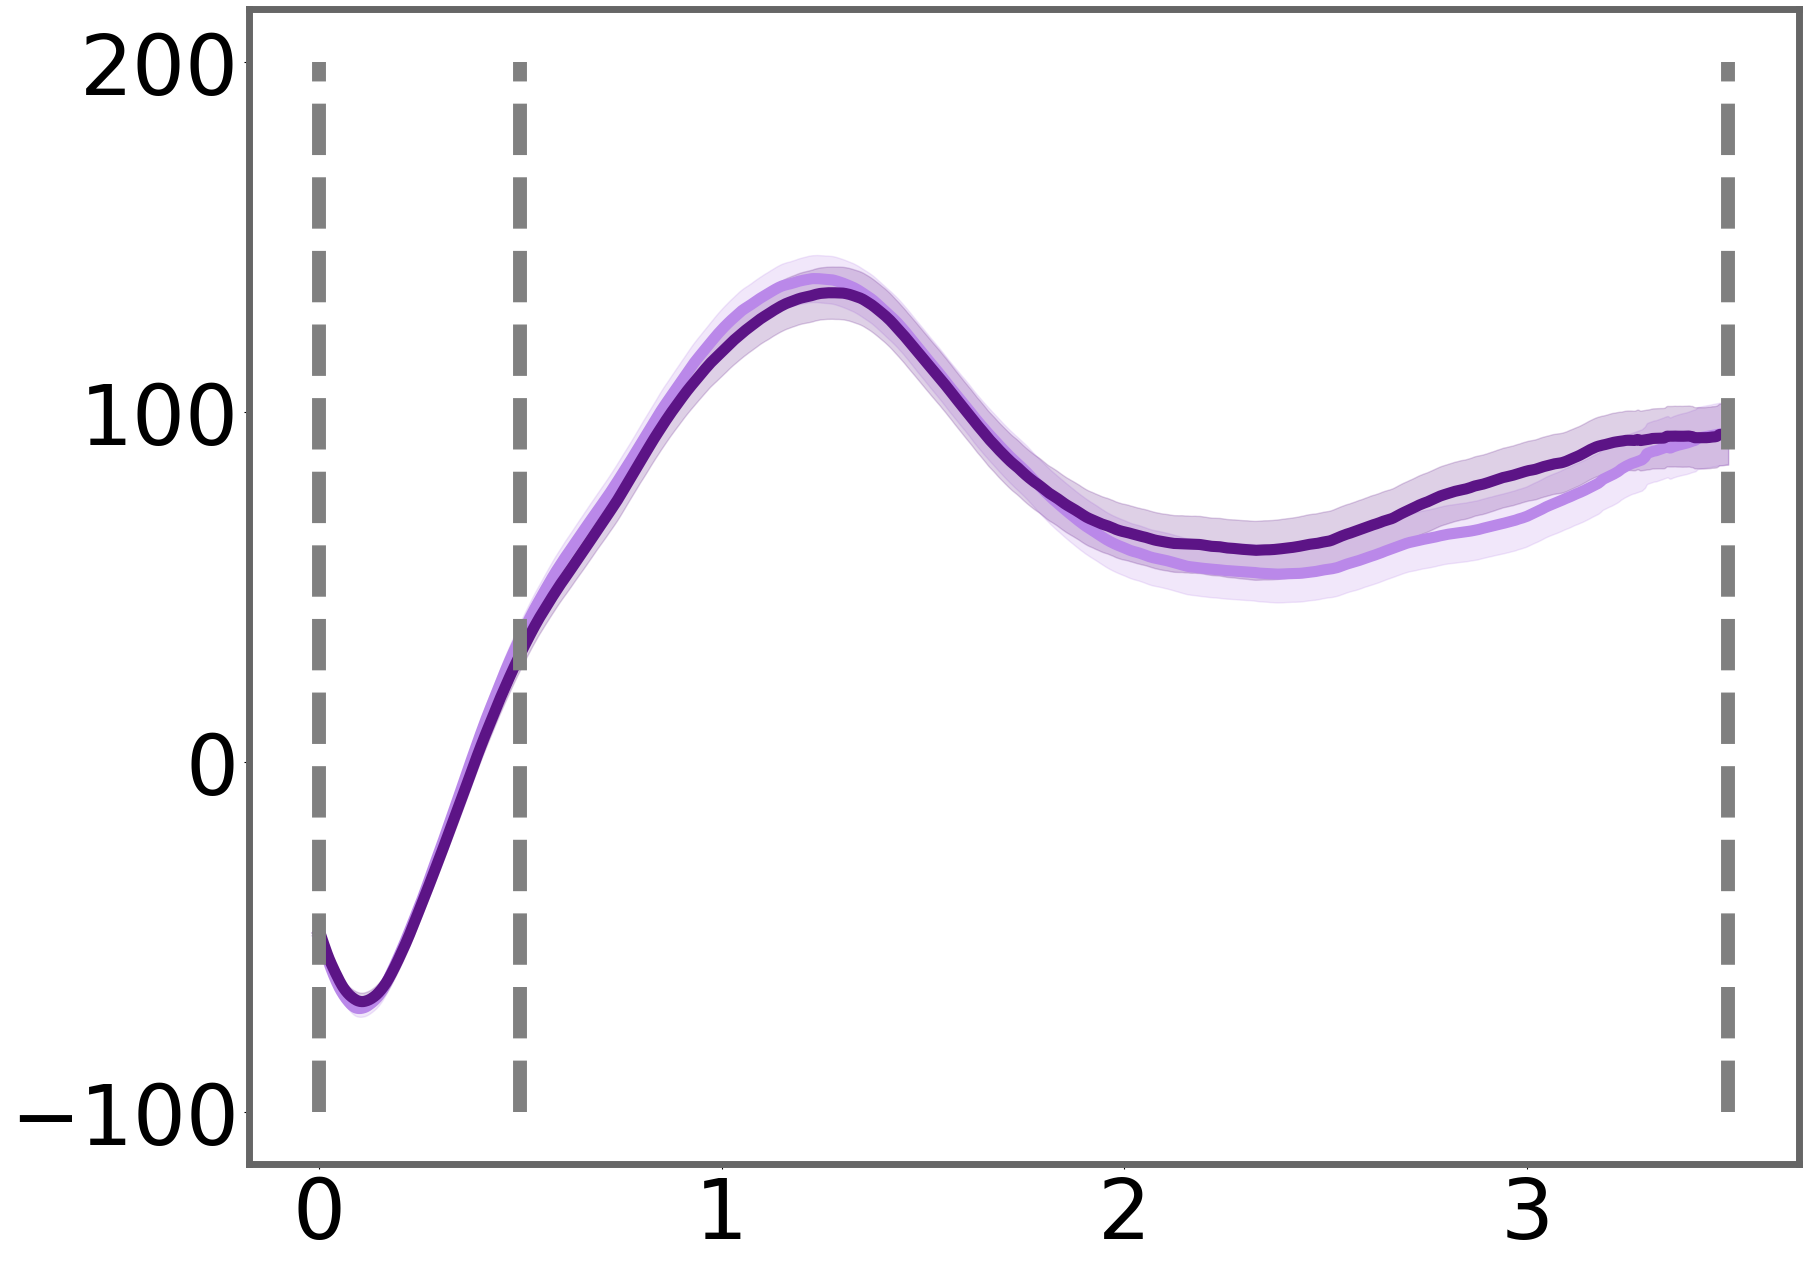

In [41]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

In [42]:
result_visual = cluster_permutation_test(
    data_df=dsPup_visual,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 8 timepoints (indices 11-18), statistic=-33.005
  Largest observed cluster: 8 timepoints (indices 11-18), statistic=-33.005

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -33.005
  Permutation p-value: 0.0260


In [43]:
cluster_pvalues = [
    np.mean(cluster_stat > result_visual['null_distribution'])
    for cluster_stat in [result_visual['observed_stats'][cluster].sum() 
                         for cluster in result_visual['observed_clusters']]
]
cluster_t = [time for time, p in zip(result_visual['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in result_visual['observed_clusters']]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.0346, 0.0134]
Clusters: [(1.1, 1.9000000000000001), (2.1, 3.5)]


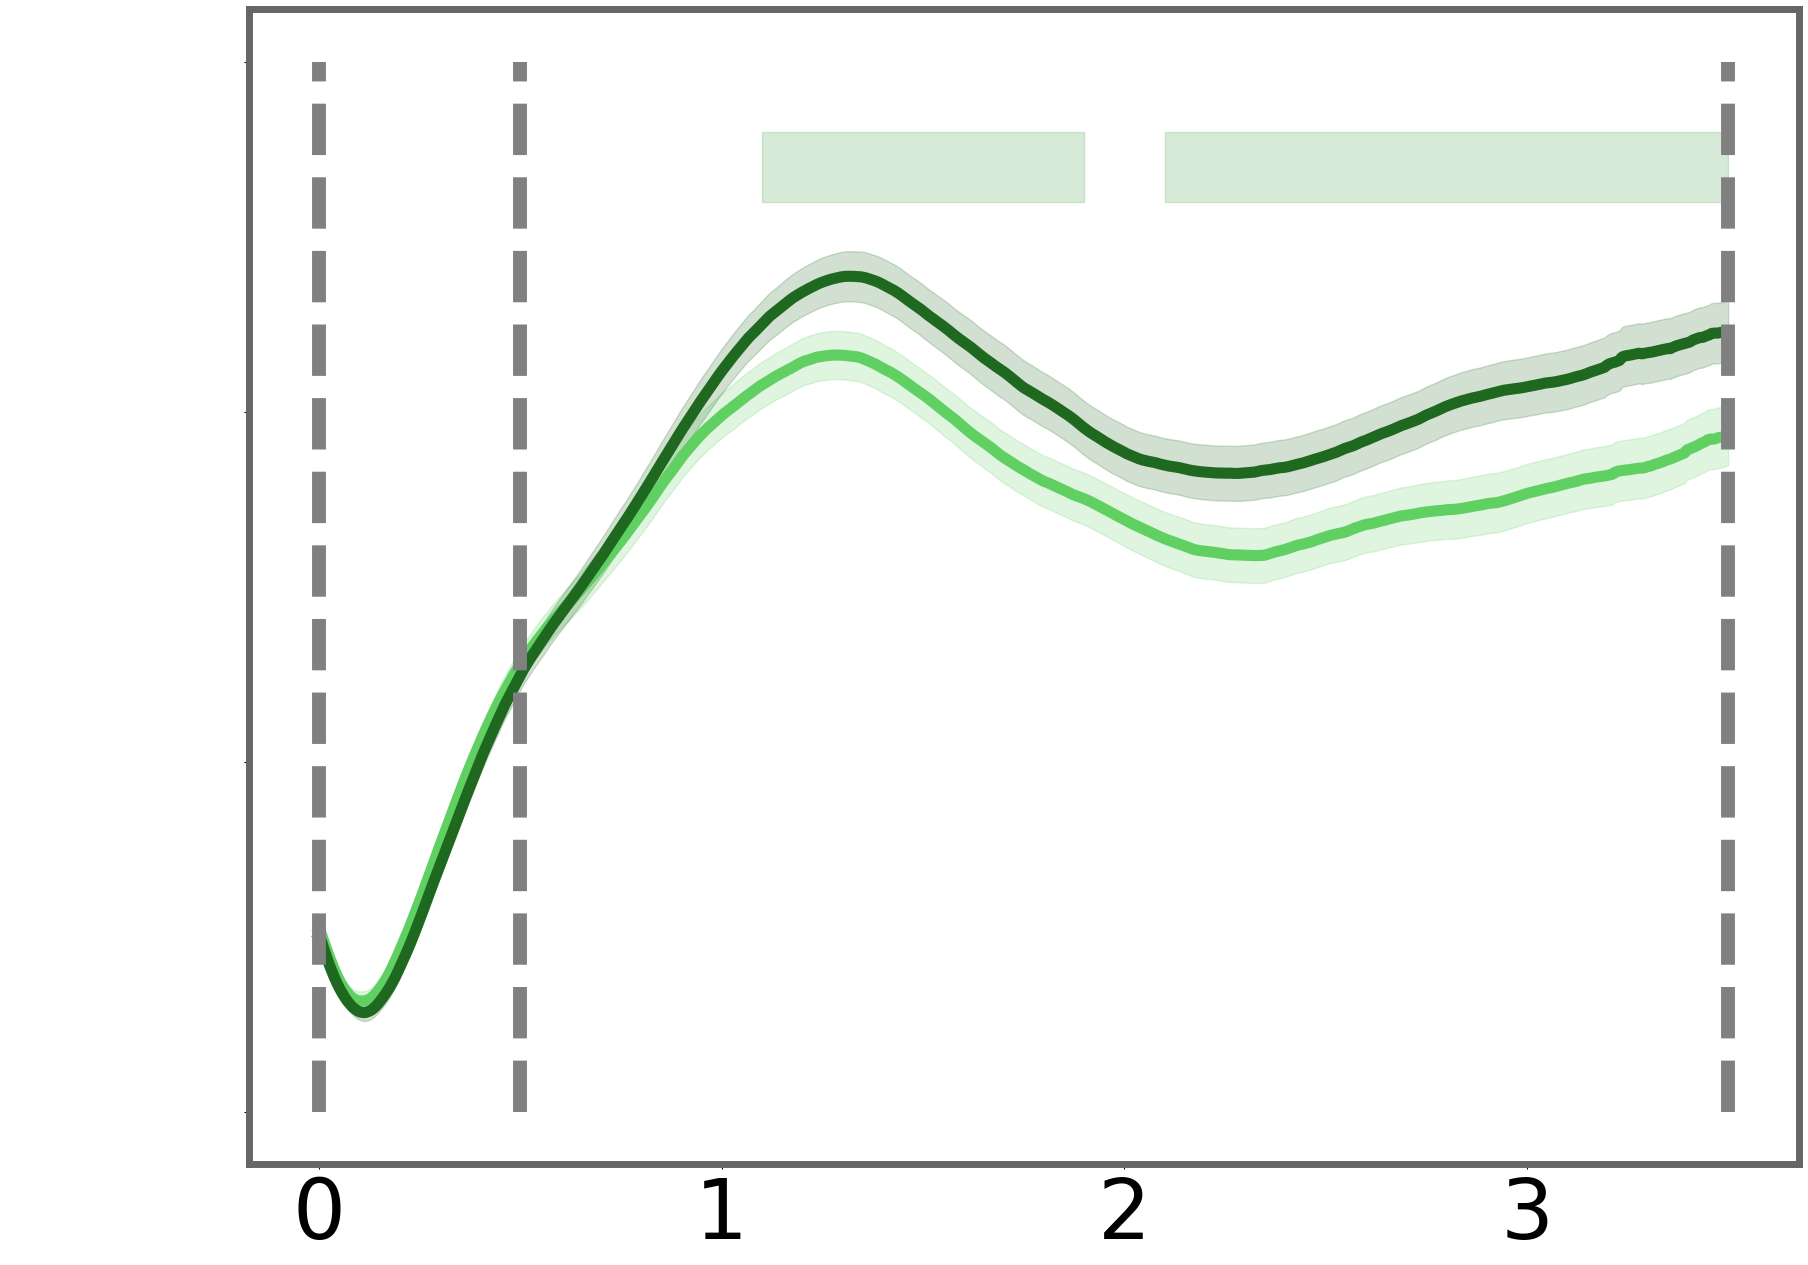

In [44]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]
[plt.fill_between(i,160,180,color = "#359937",alpha = 0.2) for i in cluster_t]

plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

### incorrect

In [45]:
#prepare for permutation
a = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[pupNorm.TRIALID.isin(incorrTrials)][['trlType','cuedItemBri']]],axis = 1)

dsPup_visual = dsPup[dsPup.trlType == 'visual'].reset_index(drop=True)
dsPup_verbal = dsPup[dsPup.trlType == 'verbal'].reset_index(drop=True)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\3570384425.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  a = a.groupby(a.columns // 100, axis=1).mean()


In [46]:
pupMean = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
pupSd = pupNorm[pupNorm.TRIALID.isin(incorrTrials)].drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

In [47]:
result_verbal = cluster_permutation_test(
    data_df=dsPup_verbal,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  No significant clusters found in observed data


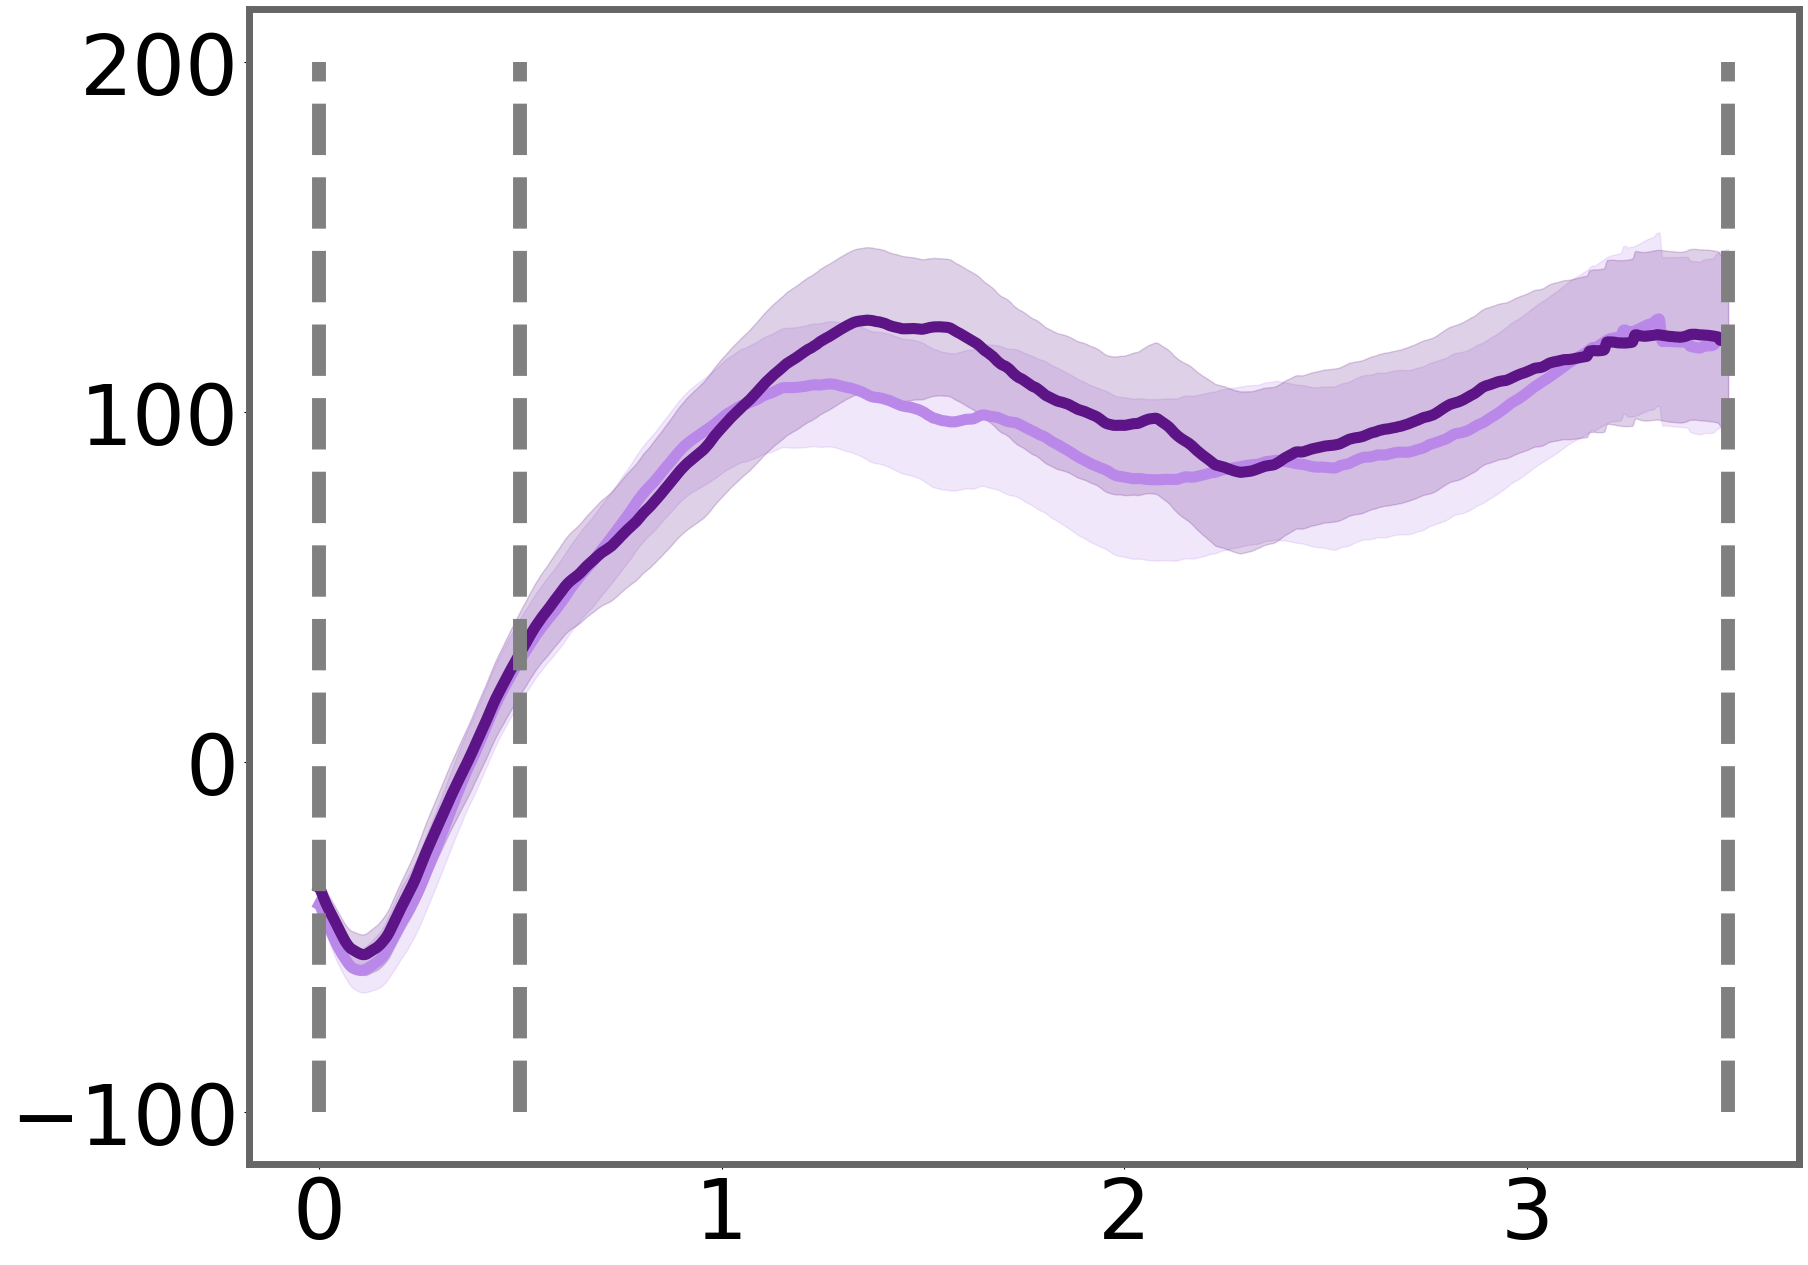

In [48]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

In [49]:
result_visual = cluster_permutation_test(
    data_df=dsPup_visual,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 3 timepoints (indices 0-2), statistic=-7.366
  Largest observed cluster: 3 timepoints (indices 0-2), statistic=-7.366

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -7.366
  Permutation p-value: 0.1516


In [50]:
cluster_pvalues = [
    np.mean(cluster_stat > result_visual['null_distribution'])
    for cluster_stat in [result_visual['observed_stats'][cluster].sum() 
                         for cluster in result_visual['observed_clusters']]
]
cluster_t = [time for time, p in zip(result_visual['observed_clusters'], cluster_pvalues) if p < 0.05]
cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in cluster_t]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.0726]
Clusters: []


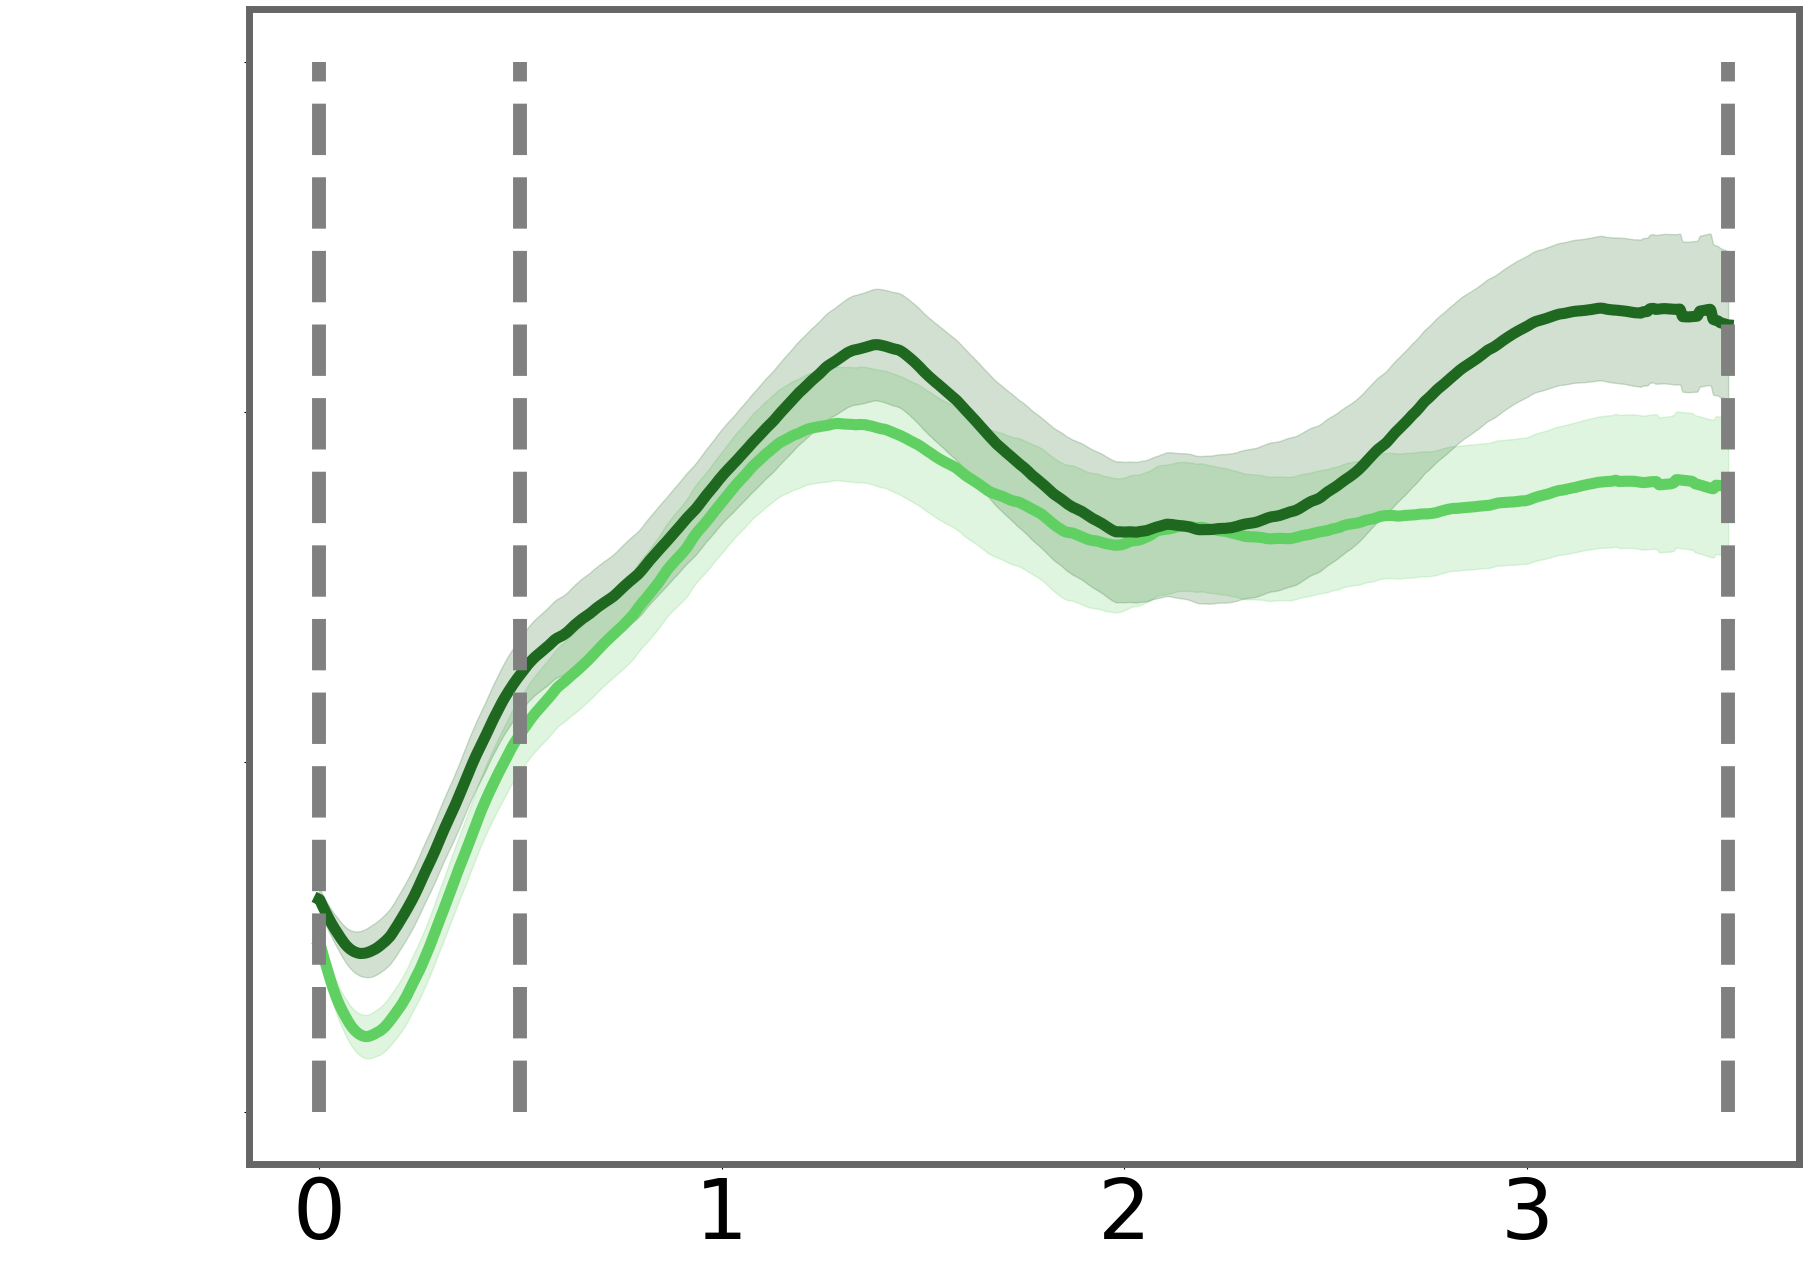

In [51]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]
[plt.fill_between(i,160,180,color = "#359937",alpha = 0.2) for i in cluster_t]

plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

# Figure 3A


In [90]:
colors = [ '#afcbf0','#559ec9','#3f5ba0']


In [91]:
vviq = pd.read_csv('./vviq/vviq_allSubj.csv')

In [ ]:
vviqLow = np.percentile(vviq.vviq,33),
vviqHigh = np.percentile(vviq.vviq,66)

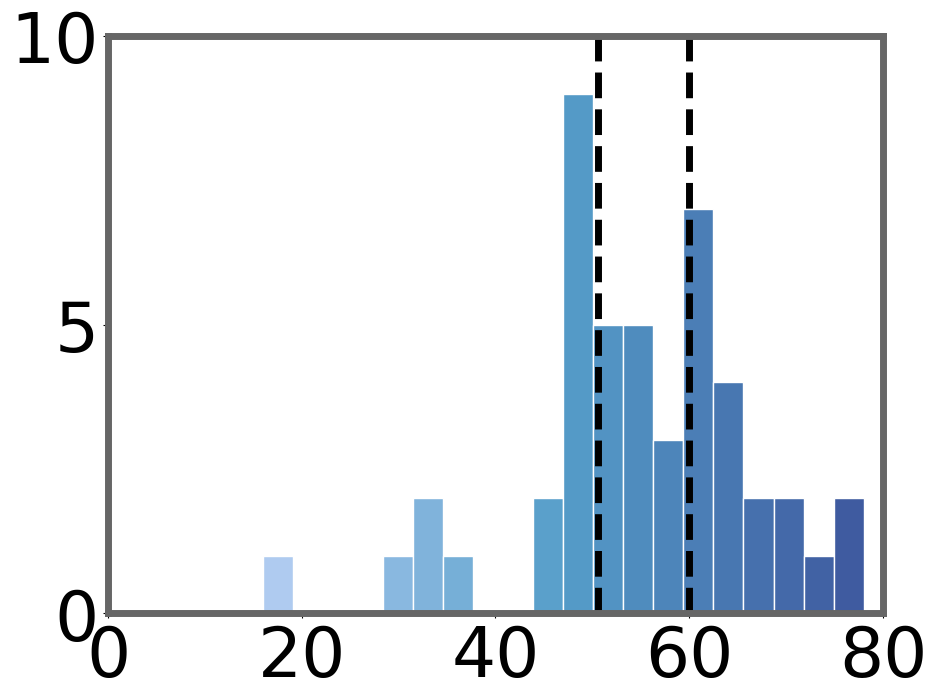

In [ ]:
fs(10,7.5)

binNum = 20
ax = sns.histplot(vviq[vviq.subj.isin(vviq.subj.unique())].vviq, bins=binNum)

# Create the colored bins
cm = LinearSegmentedColormap.from_list("Custom", colors, N=binNum)
[p.set(color=cm(n), linewidth=1, edgecolor='white') for n, p in enumerate(ax.patches)]

ax.tick_params(labelsize=40)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(20))

plt.vlines(vviqHigh, 0, 150, linestyles='dashed', colors='black', linewidth=5)
plt.vlines(vviqLow[0], 0, 150, linestyles='dashed', colors='black', linewidth=5)

plt.xlim(0, 80)
plt.ylim(0, 10)

plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

# Hide axis labels
ax.set_xlabel('')
ax.set_ylabel('')

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

# Figure 3B

In [109]:
pupTag = pupNorm.iloc[:,[0,-3,-2,-1]]
pupTag['meanPup'] = pupNorm.iloc[:,1100:1800].mean(axis =1)

pupVviqMean = pupTag.groupby(['participant','trlType','cuedItemBri']).mean(numeric_only=True)
pupVviqMean = pupVviqMean.loc[:,:,'night'] - pupVviqMean.loc[:,:,'day']
pupVviqMean = pupVviqMean.reset_index().merge(vviq[['subj','vviq']],how = 'left',left_on='participant',right_on='subj')

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_17100\3330537772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupTag['meanPup'] = pupNorm.iloc[:,1100:1800].mean(axis =1)


### semantic 

In [128]:
verbal_vviq = pupVviqMean[pupVviqMean.trlType == 'verbal'].vviq
verbal_pup = pupVviqMean[pupVviqMean.trlType == 'verbal'].meanPup

result = linregress(verbal_vviq, verbal_pup)

# Bayesian correlation
corr_result = pg.corr(verbal_vviq, verbal_pup, method='pearson')
bf = corr_result['BF10'].values[0]  # Bayes Factor

print(f'Verbal: slope={result.slope:.3f}, r={result.rvalue:.3f}, p={result.pvalue:.3f}')
print(f'Bayes Factor: {float(bf):.3f}')


Verbal: slope=1.542, r=0.335, p=0.026
Bayes Factor: 2.069


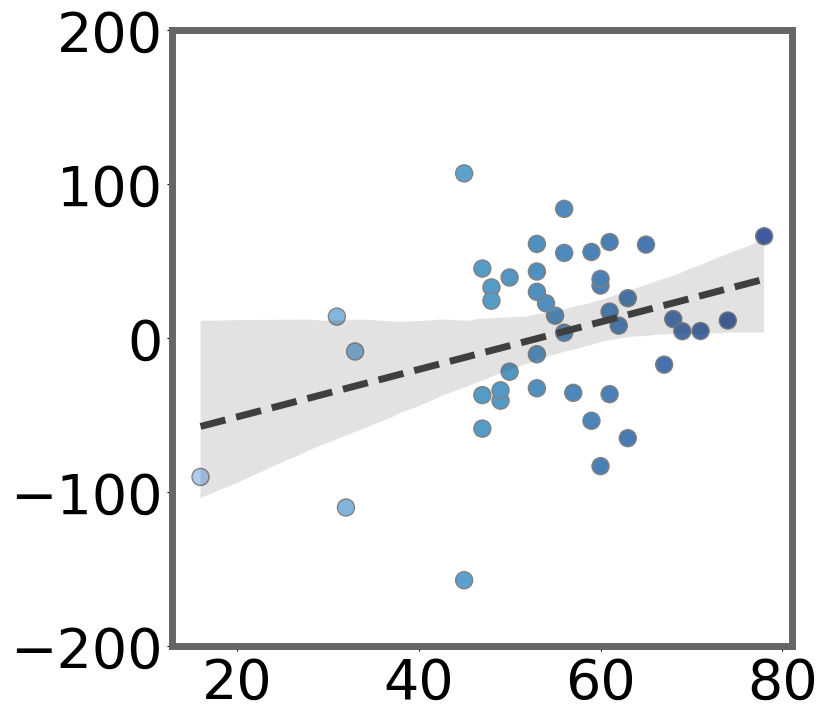

In [111]:
fs(8,8)
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=44)
qq = [mcolors.rgb2hex(cmap(x)[:3]) for x in range(pupVviqMean.vviq.nunique())]
fig,ax = plt.subplots()

# Add regression line
sns.regplot(
    x='vviq', y='meanPup', data=pupVviqMean[pupVviqMean.trlType =='verbal'], scatter=False,
    line_kws={'color': "#3F3F3F", 'linewidth': 5, 'linestyle': '--'},
    ax=plt.gca()
)
plt.scatter(
    pupVviqMean[pupVviqMean.trlType =='verbal']['vviq'], pupVviqMean[pupVviqMean.trlType =='verbal']['meanPup'], 
    c=pupVviqMean[pupVviqMean.trlType =='verbal']['vviq'], cmap=cmap, s=150, alpha=1, edgecolor='grey',zorder = 0,
)

ax.set_xlabel('')
ax.set_ylabel('')

plt.ylim(-200,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.tick_params(labelsize=40)
plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

### visual

In [130]:
visual_vviq = pupVviqMean[pupVviqMean.trlType == 'visual'].vviq
visual_pup = pupVviqMean[pupVviqMean.trlType == 'visual'].meanPup

result = linregress(visual_vviq, visual_pup)

# Bayesian correlation
corr_result = pg.corr(visual_vviq, visual_pup, method='pearson')
bf = corr_result['BF10'].values[0]  # Bayes Factor

print(f'visual: slope={result.slope:.3f}, r={result.rvalue:.3f}, p={result.pvalue:.3f}')
print(f'Bayes Factor: {float(bf):.3f}')


visual: slope=-0.831, r=-0.147, p=0.342
Bayes Factor: 0.291


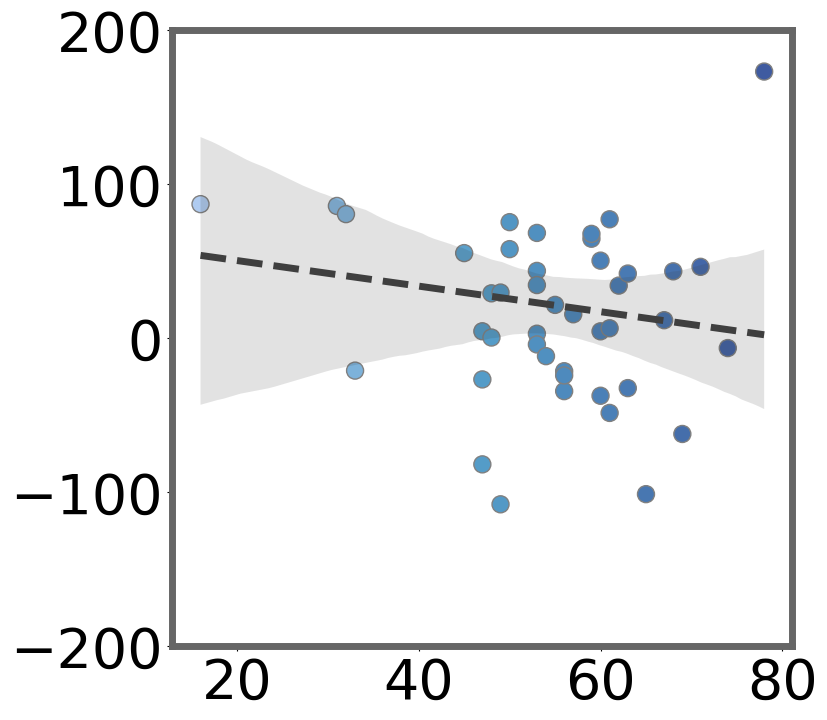

In [113]:
fs(8,8)

cmap = LinearSegmentedColormap.from_list("Custom", colors, N=44)
qq = [mcolors.rgb2hex(cmap(x)[:3]) for x in range(pupVviqMean.vviq.nunique())]
fig,ax = plt.subplots()

# Add regression line
sns.regplot(
    x='vviq', y='meanPup', data=pupVviqMean[pupVviqMean.trlType =='visual'], scatter=False,
    line_kws={'color': "#3F3F3F", 'linewidth': 5, 'linestyle': '--'},
    ax=plt.gca()
)
plt.scatter(
    pupVviqMean[pupVviqMean.trlType =='visual']['vviq'], pupVviqMean[pupVviqMean.trlType =='visual']['meanPup'], 
    c=pupVviqMean[pupVviqMean.trlType =='visual']['vviq'], cmap=cmap, s=150, alpha=1, edgecolor='grey',zorder = 0,
)

ax.set_xlabel('')
ax.set_ylabel('')

plt.ylim(-200,200)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.tick_params(labelsize=40)
plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

# Figure 3C

In [114]:
highImagers = vviq[vviq.vviq > vviqHigh].subj.values
lowImagers = vviq[vviq.vviq < vviqLow].subj.values
MedImagers = vviq[(vviq.vviq >= vviqLow) & (vviq.vviq <= vviqHigh)].subj.values

pupHighImagers = pupNorm[pupNorm.participant.isin(highImagers)]
pupMedImagers = pupNorm[pupNorm.participant.isin(MedImagers)]
pupLowImagers = pupNorm[pupNorm.participant.isin(lowImagers)]

In [116]:
cList = ['#ba88e9','#5c1486','#60d062','#1e681f']
lenData = 3500

### strong imagers

In [115]:
pupMean = pupHighImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
pupSd = pupHighImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

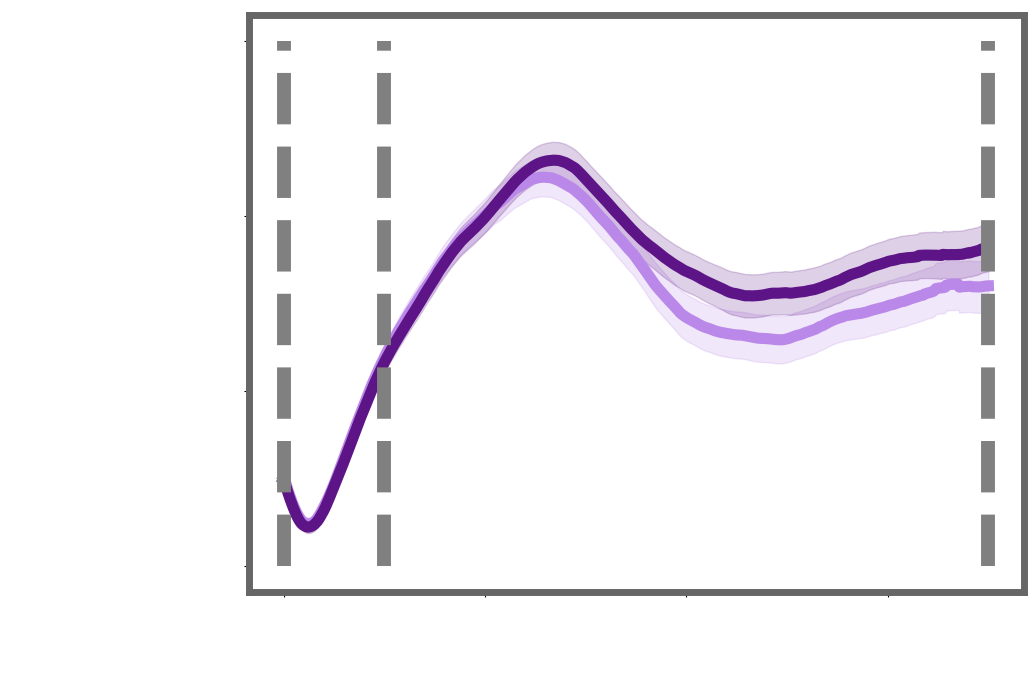

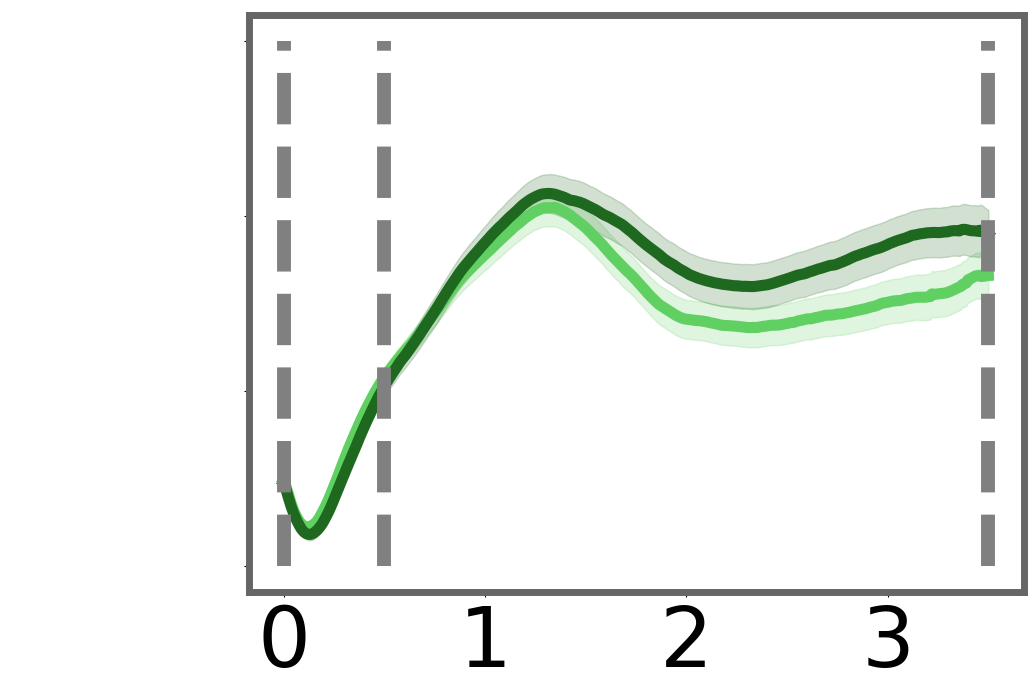

In [121]:
fs(10,7.5)

fig,ax = plt.subplots()
x = np.linspace(0,3.5,3500)
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,c = 'white')

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

### medium imagers

In [122]:
pupMean = pupMedImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
pupSd = pupMedImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

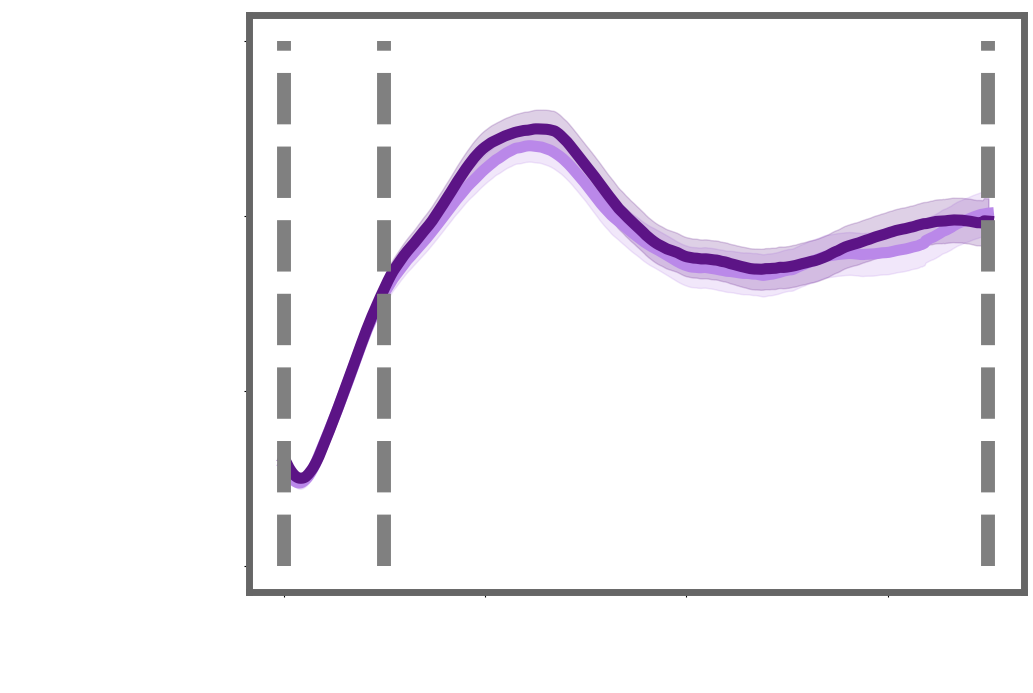

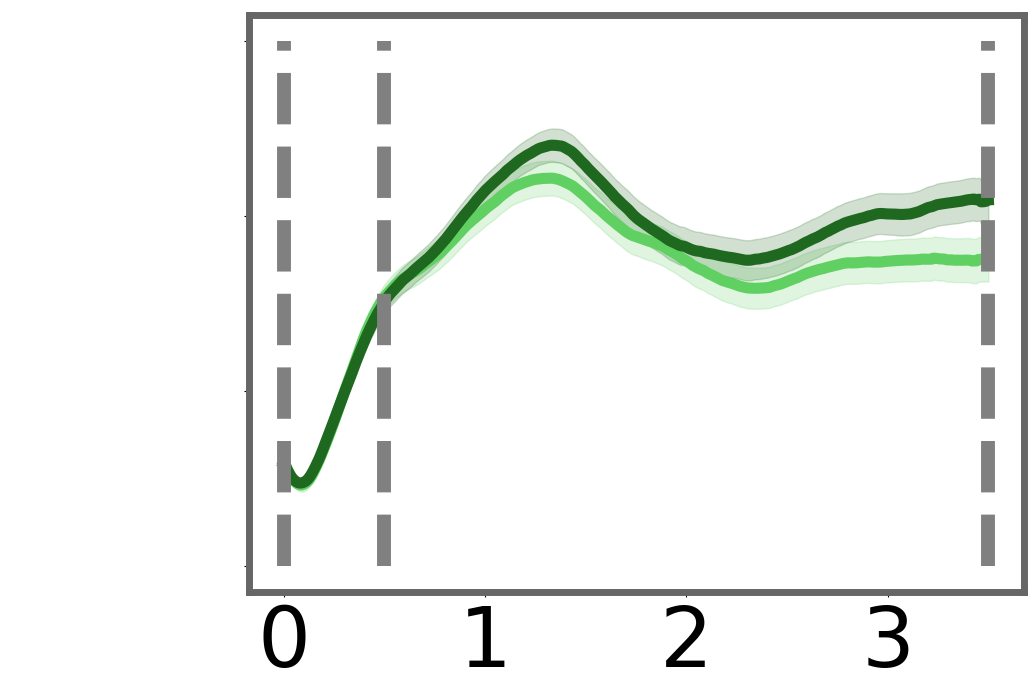

In [123]:
fs(10,7.5)

fig,ax = plt.subplots()
x = np.linspace(0,3.5,3500)
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,c = 'white')

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)

### weak imagers

In [124]:
pupMean = pupLowImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
pupSd = pupLowImagers.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

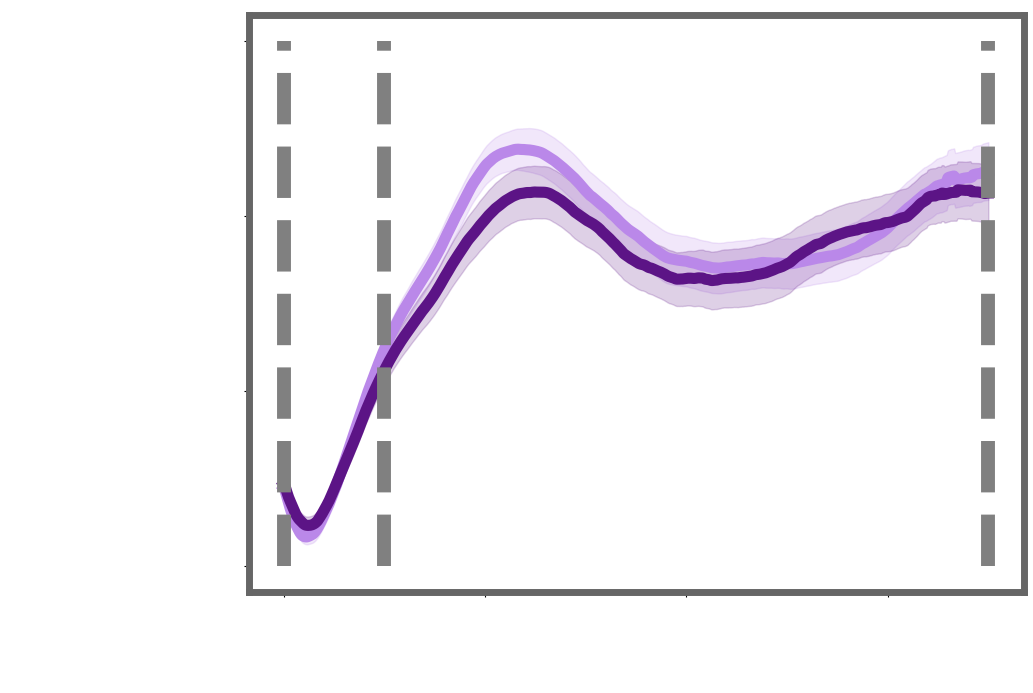

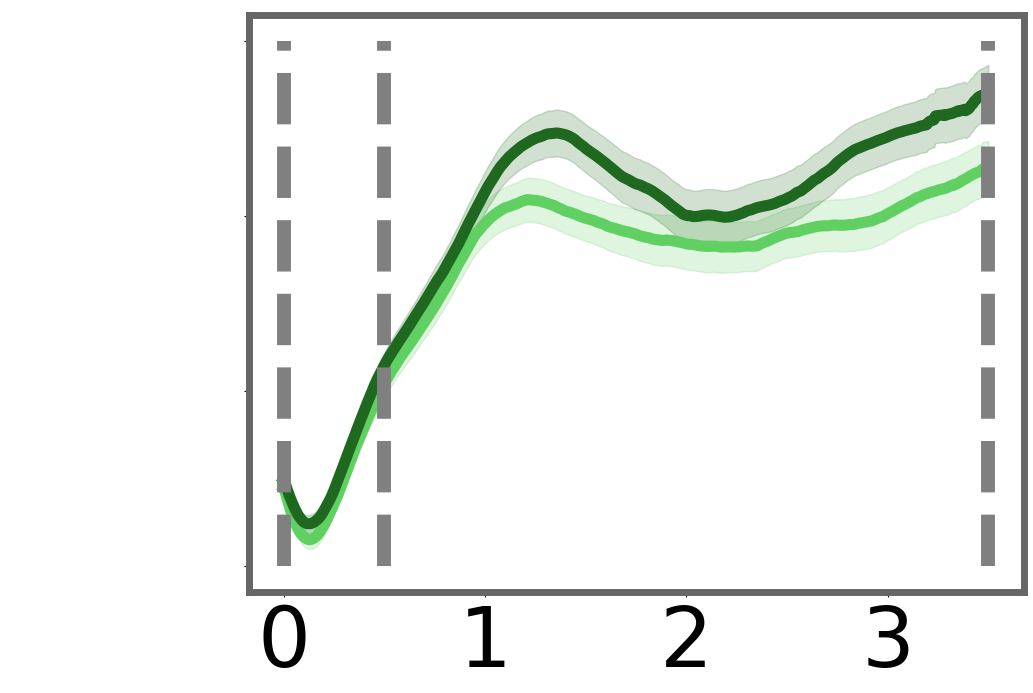

In [125]:
fs(10,7.5)

fig,ax = plt.subplots()
x = np.linspace(0,3.5,3500)
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [0,1]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [0,1]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,c = 'white')

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


fs(10,7.5)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]


plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60,)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)